In [1]:
import os
from six.moves import urllib
import numpy as np
import pandas as pd
import warnings

from matplotlib import pyplot as plt
#import seaborn as sns

from IPython.core.pylabtools import figsize
#figsize(11, 9)
import time
import tensorflow as tf
import tensorflow_probability as tfp

import sys
sys.path.insert(1, '/Users/milesturpin/Dev/latent_variable_nn')
sys.path.insert(1, '/Users/milesturpin/Dev/latent_variable_nn/models')

from models.multilevel_layers import MultilevelDense

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential
import datetime


tfd = tfp.distributions

/Users/milesturpin/miniconda3/envs/latent2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/milesturpin/miniconda3/envs/latent2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/milesturpin/miniconda3/envs/latent2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/milesturpin/min

In [2]:
%load_ext tensorboard

# Fake data

In [3]:
np.random.seed(7)

#### diff data

In [4]:
np.random.seed(7)

n1=20+20
x1 = np.random.randn(n1)
gid1 = np.zeros(n1)
y1 = 2*x1 + np.random.randn(n1)

n2=10+10
x2 = np.random.randn(n2)
gid2 = np.zeros(n2) + 1
y2 = 1.5*x2 + 2 +  np.random.randn(n2)

n3=5+5
x3 = np.random.randn(n3)
gid3 = np.zeros(n3) + 2
y3 = 1*x3 + 2 + np.random.randn(n3)

#### same data

In [5]:
np.random.seed(8)

n1=20+20
x1 = np.random.randn(n1)
gid1 = (np.zeros(n1)).astype(np.int32)
y1 = 1.2*x1 + np.random.randn(n1)/2

n2=10+10
x2 = np.random.randn(n2)
gid2 = (np.zeros(n2) + 1).astype(np.int32)
y2 = 0.8*x2 +  np.random.randn(n2)/2

n3=5+5
x3 = np.random.randn(n3)
gid3 = (np.zeros(n3) + 2).astype(np.int32)
y3 = x3 + np.random.randn(n3)/2

(-4, 4.5)

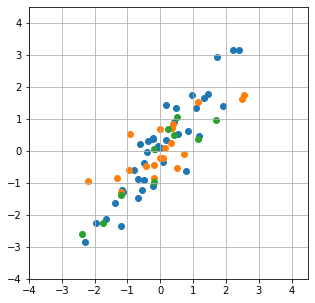

In [6]:
plt.figure(figsize=(5,5))
plt.scatter(x1,y1)
plt.scatter(x2,y2)
plt.scatter(x3,y3)
plt.grid(True)
plt.ylim([-4,4.5])
plt.xlim([-4,4.5])

In [7]:
x = np.concatenate([x1,x2,x3])
gid = np.concatenate([gid1,gid2,gid3]).astype(np.int32)
y = np.concatenate([y1,y2,y3])

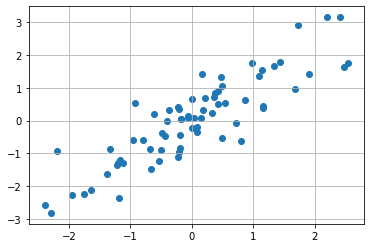

In [8]:
plt.scatter(x,y)
plt.grid(True)

In [9]:
x_train, x_test, y_train, y_test, gid_train, gid_test = train_test_split(x, y, gid, stratify=gid)

In [10]:
def regression(x, y, gid):
    
    x_train, x_test, y_train, y_test, gid_train, gid_test = train_test_split(
        x, y, gid, stratify=gid, random_state=9, test_size=0.5)
    
    if len(x_train.shape) == 1:
        x_train = np.expand_dims(x_train, axis=1)
        x_test = np.expand_dims(x_test, axis=1)
    
    model = tf.keras.models.Sequential([
        #tf.keras.layers.Dense(4),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1),
                  loss='mse', metrics=['mse'])
    
    model.fit(x_train, y_train, batch_size=len(x), epochs=200, verbose=False)
    
    print('MSE', round(mean_squared_error(y_test, model.predict(x_test)), 3))
    print('R2', round(r2_score(y_test, model.predict(x_test)), 3))
    
    m, b = model.get_weights()
    m, b = round(m[0,0], 3), round(b[0], 3)
    print(m,b)
    
    return model, (m, b)

In [11]:
model, (m, b) = regression(x, y, gid)

MSE 0.349
R2 0.744
1.037 0.083


In [12]:
xs = np.linspace(-3, 3, 5)
ys = m*xs + b

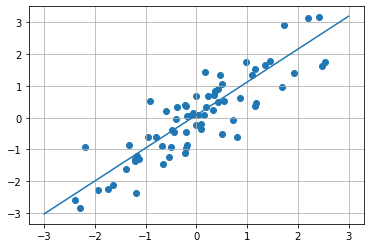

In [13]:
plt.scatter(x,y)
plt.plot(xs,ys)
plt.grid(True)

In [14]:
model1, (m1, b1) = regression(x1, y1, gid1)
model2, (m2, b2) = regression(x2, y2, gid2)
model3, (m3, b3) = regression(x3, y3, gid3)

MSE 0.259
R2 0.795
1.199 0.101
MSE 0.156
R2 0.839
0.621 0.014
MSE 0.777
R2 0.547
0.877 -0.592


In [15]:
xs = np.linspace(-3, 3, 5)
ys1 = m1*xs + b1
ys2 = m2*xs + b2
ys3 = m3*xs + b3

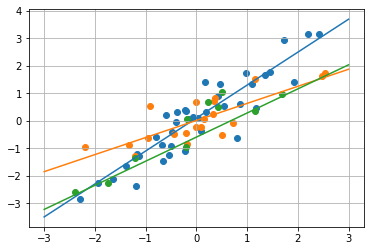

In [16]:
plt.scatter(x1,y1)
plt.scatter(x2,y2)
plt.scatter(x3,y3)
plt.plot(xs,ys1)
plt.plot(xs,ys2)
plt.plot(xs,ys3)
plt.grid(True)

### Dense variational

In [33]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

In [34]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t[..., :n],
                       scale=tf.nn.softplus(t[..., n:])),
            reinterpreted_batch_ndims=1)),
    ])


In [35]:
# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t, scale=1),
            reinterpreted_batch_ndims=1)),
    ])

In [36]:
def bayesian_regression(x, y, gid):
    
    x_train, x_test, y_train, y_test, gid_train, gid_test = train_test_split(
        x, y, gid, stratify=gid, random_state=9, test_size=0.5)
    
    if len(x_train.shape) == 1:
        x_train = np.expand_dims(x_train, axis=1)
        x_test = np.expand_dims(x_test, axis=1)
    
    model = tf.keras.models.Sequential([
        tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable, kl_weight=1/x.shape[0])
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.1),
                  loss='mse', metrics=['mse'])
    
    model.fit(x_train, y_train, batch_size=len(x), epochs=1000, verbose=False)
    
    print('MSE', round(mean_squared_error(y_test, model.predict(x_test)), 3))
    print('R2', round(r2_score(y_test, model.predict(x_test)), 3))
    
    kernel, prior = model.get_weights()
    
    
    #m, b = round(m[0,0], 3), round(b[0], 3)
    print(kernel, prior)
    
    return model, (kernel, prior)

In [37]:
model, (kernel, prior) = bayesian_regression(x, y, gid)

MSE 0.386
R2 0.669
[ 1.0440022   0.12412077 -2.6520019  -2.276313  ] [1.0080967  0.05670125]


In [38]:
def get_pred_matrix(xs, kernel, prior):
    m_mu, b_mu, m_sig, b_sig = kernel
    m_sig, b_sig = tf.nn.softplus([ m_sig, b_sig])
    
    m_range = np.linspace(-2*m_sig, 2*m_sig, 10)
    b_range = np.linspace(-2*b_sig, 2*b_sig, 10)
    
    pred_matrix = np.outer(m_mu+m_range[::-1], xs) + np.expand_dims(b_mu + b_range[::-1],axis=1)
    return pred_matrix

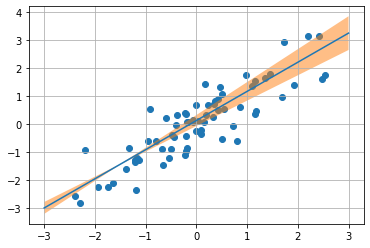

In [39]:
xs = np.linspace(-3, 3, 5)
pred_matrix = get_pred_matrix(xs, kernel, prior)

plt.scatter(x,y)
plt.plot(xs,np.mean(pred_matrix, axis=0))
plt.fill_between(xs, np.max(pred_matrix, axis=0),  np.min(pred_matrix, axis=0), alpha=0.5)
plt.grid(True)

In [40]:
pred_matrix

array([[-3.22124185, -1.45083331,  0.31957522,  2.08998375,  3.86039229],
       [-3.17382938, -1.44884424,  0.2761409 ,  2.00112604,  3.72611118],
       [-3.12641692, -1.44685517,  0.23270658,  1.91226832,  3.59183007],
       [-3.07900445, -1.4448661 ,  0.18927225,  1.82341061,  3.45754896],
       [-3.03159199, -1.44287703,  0.14583793,  1.73455289,  3.32326785],
       [-2.98417952, -1.44088796,  0.10240361,  1.64569518,  3.18898674],
       [-2.93676706, -1.43889888,  0.05896929,  1.55683746,  3.05470563],
       [-2.88935459, -1.43690981,  0.01553497,  1.46797975,  2.92042453],
       [-2.84194213, -1.43492074, -0.02789935,  1.37912203,  2.78614342],
       [-2.79452966, -1.43293167, -0.07133368,  1.29026432,  2.65186231]])

#### by group

In [41]:
model1, (kernel1, prior1) = bayesian_regression(x1, y1, gid1)
model2, (kernel2, prior2) = bayesian_regression(x2, y2, gid2)
model3, (kernel3, prior3) = bayesian_regression(x3, y3, gid3)

MSE 0.31
R2 0.788
[ 1.1460199   0.14996384 -2.3703656  -2.1637685 ] [ 1.3346298  -0.00533285]
MSE 0.158
R2 0.743
[ 0.5871421   0.10643046 -1.4615837  -1.8476149 ] [ 0.5931399 -0.1021587]
MSE 1.239
R2 0.8
[ 0.8246719  -0.48617926 -1.499122   -1.534578  ] [ 1.0595329 -0.6704545]


In [42]:
xs = np.linspace(-2, 2, 5)
ys1 = m1*xs + b1
ys2 = m2*xs + b2
ys3 = m3*xs + b3

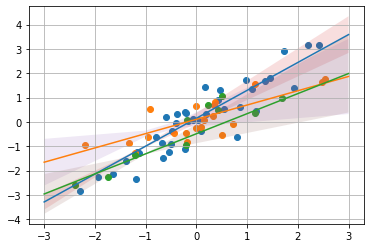

In [43]:
plt.scatter(x1,y1)
plt.scatter(x2,y2)
plt.scatter(x3,y3)

xs = np.linspace(-3, 3, 10)

pred_matrix = get_pred_matrix(xs, kernel1, prior1)
plt.plot(xs,np.mean(pred_matrix, axis=0))
plt.fill_between(xs, np.max(pred_matrix, axis=0),  np.min(pred_matrix, axis=0), alpha=0.15)

pred_matrix = get_pred_matrix(xs, kernel2, prior2)
plt.plot(xs,np.mean(pred_matrix, axis=0))
plt.fill_between(xs, np.max(pred_matrix, axis=0),  np.min(pred_matrix, axis=0), alpha=0.15)

pred_matrix = get_pred_matrix(xs, kernel3, prior3)
plt.plot(xs,np.mean(pred_matrix, axis=0))
plt.fill_between(xs, np.max(pred_matrix, axis=0),  np.min(pred_matrix, axis=0), alpha=0.15)

plt.grid(True)

### one hot / deep 

In [44]:
def deep_regression(x, y, gid):
    
    x_train, x_test, y_train, y_test, gid_train, gid_test = train_test_split(
        x, y, gid, stratify=gid, random_state=9, shuffle=True, test_size=0.5)
    
    if len(x_train.shape) == 1:
        x_train = np.expand_dims(x_train, axis=1)
        x_test = np.expand_dims(x_test, axis=1)
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(4, activation='sigmoid'),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.01),
                  loss='mse', metrics=['mse'])
    
    model.fit(x_train, y_train, batch_size=len(x), epochs=1000, verbose=False)
    
    print('MSE', round(mean_squared_error(y_test, model.predict(x_test)), 3))
    print('R2', round(r2_score(y_test, model.predict(x_test)), 3))
    
    return model

In [45]:
xp = np.concatenate([np.expand_dims(x,axis=1), to_categorical(gid)], axis=1)
model = deep_regression(xp, y, gid)

MSE 0.343
R2 0.748


In [46]:
xs = np.linspace(-3, 3, 5)
xs = np.expand_dims(xs, 1)
xs = np.concatenate([xs, np.tile(np.array([0,0,0]), 5).reshape((5,3))], axis=1)
ys = model.predict(xs)

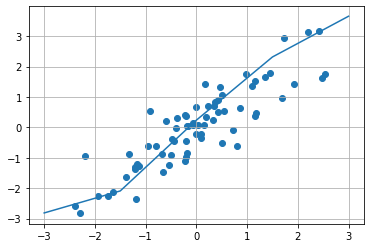

In [47]:
plt.scatter(x,y)
plt.plot(np.linspace(-3, 3, 5),ys)
plt.grid(True)

In [48]:
xs1 = np.linspace(-3, 3, 5)
xs1 = np.expand_dims(xs1, 1)
xs1 = np.concatenate([xs1, np.tile(np.array([1,0,0]), 5).reshape((5,3))], axis=1)
ys1 = model.predict(xs1)

xs2 = np.linspace(-3, 3, 5)
xs2 = np.expand_dims(xs2, 1)
xs2 = np.concatenate([xs2, np.tile(np.array([0,1,0]), 5).reshape((5,3))], axis=1)
ys2 = model.predict(xs2)

xs3 = np.linspace(-3, 3, 5)
xs3 = np.expand_dims(xs3, 1)
xs3 = np.concatenate([xs3, np.tile(np.array([0,0,1]), 5).reshape((5,3))], axis=1)
ys3 = model.predict(xs3)

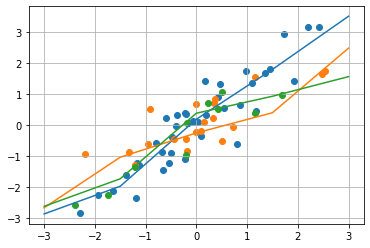

In [49]:
plt.scatter(x1,y1)
plt.scatter(x2,y2)
plt.scatter(x3,y3)

plt.plot(np.linspace(-3, 3, 5),ys1)
plt.plot(np.linspace(-3, 3, 5),ys2)
plt.plot(np.linspace(-3, 3, 5),ys3)
plt.grid(True)

### one hot deep bayesian regression

In [50]:
def deep_bayesian_regression(x, y, gid):
    
    x_train, x_test, y_train, y_test, gid_train, gid_test = train_test_split(
        x, y, gid, stratify=gid, random_state=9, test_size=0.5)
    
    if len(x_train.shape) == 1:
        x_train = np.expand_dims(x_train, axis=1)
        x_test = np.expand_dims(x_test, axis=1)
    
    model = tf.keras.models.Sequential([
        tfp.layers.DenseVariational(4, posterior_mean_field, prior_trainable, kl_weight=1/x.shape[0],
                                    activation='sigmoid'),
        tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable, kl_weight=1/x.shape[0])
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.1),
                  loss='mse', metrics=['mse'])
    
    model.fit(x_train, y_train, batch_size=len(x), epochs=1000, verbose=False)
    
    print('MSE', round(mean_squared_error(y_test, model.predict(x_test)), 3))
    print('R2', round(r2_score(y_test, model.predict(x_test)), 3))
    
    return model

In [51]:
xp = np.concatenate([np.expand_dims(x,axis=1), to_categorical(gid)], axis=1)
model = deep_bayesian_regression(xp, y, gid)

MSE 0.434
R2 0.659


In [52]:
x_plot = np.linspace(-3, 3, 5)
xs = np.expand_dims(x_plot, 1)
xs = np.concatenate([xs, np.tile(np.array([0,0,0]), 5).reshape((5,3))], axis=1)
ys = model.predict(xs)

pred_matrix = np.concatenate([model.predict(xs) for _ in range(100)], axis=1).T

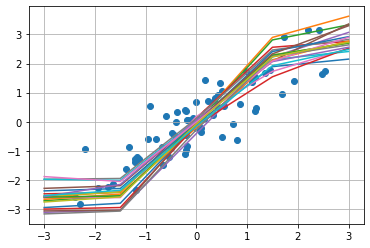

In [53]:

#pred_matrix = get_one_hot_pred_matrix(xs, kernel, prior)

plt.scatter(x,y)
#plt.plot(xs,np.mean(pred_matrix, axis=0))
#plt.fill_between(xs, np.max(pred_matrix, axis=0),  np.min(pred_matrix, axis=0), alpha=0.5)
for _ in range(20):
    plt.plot(x_plot, model.predict(xs))
plt.grid(True)

In [54]:
xs1 = np.linspace(-3, 3, 5)
xs1 = np.expand_dims(xs1, 1)
xs1 = np.concatenate([xs1, np.tile(np.array([1,0,0]), 5).reshape((5,3))], axis=1)
pred_matrix1 = np.concatenate([model.predict(xs1) for _ in range(100)], axis=1).T

xs2 = np.linspace(-3, 3, 5)
xs2 = np.expand_dims(xs2, 1)
xs2 = np.concatenate([xs2, np.tile(np.array([0,1,0]), 5).reshape((5,3))], axis=1)
pred_matrix2 = np.concatenate([model.predict(xs2) for _ in range(100)], axis=1).T

xs3 = np.linspace(-3, 3, 5)
xs3 = np.expand_dims(xs3, 1)
xs3 = np.concatenate([xs3, np.tile(np.array([0,0,1]), 5).reshape((5,3))], axis=1)
pred_matrix3 = np.concatenate([model.predict(xs3) for _ in range(100)], axis=1).T

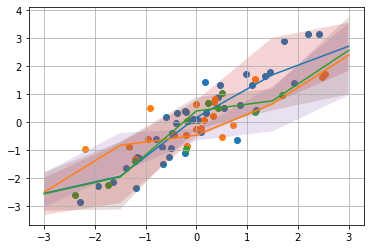

In [55]:
plt.scatter(x1,y1)
plt.scatter(x2,y2)
plt.scatter(x3,y3)

# plt.plot(np.linspace(-1, 1, 5),ys1)
# plt.plot(np.linspace(-1, 1, 5),ys2)
# plt.plot(np.linspace(-1, 1, 5),ys3)

xs1 = np.linspace(-3, 3, 5)
xs2 = np.linspace(-3, 3, 5)
xs3 = np.linspace(-3, 3, 5)

plt.plot(xs1,np.mean(pred_matrix1, axis=0))
plt.fill_between(xs1, np.max(pred_matrix1, axis=0),  np.min(pred_matrix1, axis=0), alpha=0.2)

plt.plot(xs2,np.mean(pred_matrix2, axis=0))
plt.fill_between(xs2, np.max(pred_matrix2, axis=0),  np.min(pred_matrix2, axis=0), alpha=0.2)

plt.plot(xs3,np.mean(pred_matrix3, axis=0))
plt.fill_between(xs3, np.max(pred_matrix3, axis=0),  np.min(pred_matrix3, axis=0), alpha=0.2)
plt.grid(True)

### Hierarchical

In [17]:
def prep_data(x, y, gid):
    x_train, x_test, y_train, y_test, gid_train, gid_test = train_test_split(
        x, y, gid, stratify=gid, random_state=9, test_size=0.5)

    x_train = x_train.astype(np.float32)
    x_test = x_test.astype(np.float32)
    y_train = y_train.astype(np.float32)
    y_test = y_test.astype(np.float32)
    
    if len(x_train.shape) == 1:
        x_train = np.expand_dims(x_train, axis=1)
        x_test = np.expand_dims(x_test, axis=1)
        
    if len(y_train.shape) == 1:
        y_train = np.expand_dims(y_train, axis=1)
        y_test = np.expand_dims(y_test, axis=1)

    #x_train = np.concatenate([x_train,np.zeros((len(x_train), 1)).astype(np.float32)], axis=1)
    #x_test = np.concatenate([x_test,np.zeros((len(x_train), 1)).astype(np.float32)], axis=1)
    
    train_data = [x_train, gid_train, y_train]
    test_data = [x_test, gid_test, y_test]
    
    return train_data, test_data

In [59]:


"""def multilevel_regression(x, y, gid):
    x_train, x_test, y_train, y_test, gid_train, gid_test = train_test_split(
        x, y, gid, stratify=gid, random_state=9, test_size=0.5)

    x_train = x_train.astype(np.float32)
    x_test = x_test.astype(np.float32)


    if len(x_train.shape) == 1:
        x_train = np.expand_dims(x_train, axis=1)
        x_test = np.expand_dims(x_test, axis=1)

    x_train = np.concatenate([x_train,x_train], axis=1)
    x_test = np.concatenate([x_test,x_test], axis=1)
    
#     model = tf.keras.models.Sequential([
#         #tfp.layers.DenseVariational(2, posterior_mean_field, prior_trainable, kl_weight=1/x.shape[0],
#         #                            activation='sigmoid'),
#         #tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable, kl_weight=1/x.shape[0])
#         self.ml_dense = MultilevelDense(62, num_groups=self.num_groups[0], activation='softmax')
        
#     ])
    print(x_train.dtype, y_train.dtype, gid_train.dtype)
    
    x_input = Input(shape=(2,), dtype=tf.float32)
    gid_input = Input(shape=(1,), dtype=tf.int32)
    ml_dense = MultilevelDense(1, num_groups=3, multilevel_weights=True, multilevel_bias=True)
    #print(ml_dense, ml_dense.get_weights())
    
    out = ml_dense([x_input, gid_input])
    model = Model(inputs=[x_input, gid_input], outputs=[out])
    
    #print('before', x_train.shape, gid_train.shape)
    model([x_train, gid_train])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.1),
                  loss='mse', metrics=['mse'])
    
    model.fit([x_train, gid_train], y_train, batch_size=len(x), epochs=1000, verbose=False)
    
    #print(model([x_test, gid_test]).shape)
    #preds = model([x_test, gid_test])
    #print(preds.shape,type(preds),  y_test.shape)
    #print(preds, y_test)
    #print('MSE', round(mean_squared_error(y_test, preds), 3))
    #print('R2', round(r2_score(y_test, preds), 3))
    
    return model"""

"def multilevel_regression(x, y, gid):\n    x_train, x_test, y_train, y_test, gid_train, gid_test = train_test_split(\n        x, y, gid, stratify=gid, random_state=9, test_size=0.5)\n\n    x_train = x_train.astype(np.float32)\n    x_test = x_test.astype(np.float32)\n\n\n    if len(x_train.shape) == 1:\n        x_train = np.expand_dims(x_train, axis=1)\n        x_test = np.expand_dims(x_test, axis=1)\n\n    x_train = np.concatenate([x_train,x_train], axis=1)\n    x_test = np.concatenate([x_test,x_test], axis=1)\n    \n#     model = tf.keras.models.Sequential([\n#         #tfp.layers.DenseVariational(2, posterior_mean_field, prior_trainable, kl_weight=1/x.shape[0],\n#         #                            activation='sigmoid'),\n#         #tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable, kl_weight=1/x.shape[0])\n#         self.ml_dense = MultilevelDense(62, num_groups=self.num_groups[0], activation='softmax')\n        \n#     ])\n    print(x_train.dtype, y_train.dtyp

In [18]:
train_data, test_data = prep_data(x, y, gid)

In [81]:
from models.multilevel_layers import MultilevelDense, MyDense, TFPMultilevelDense

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:


class MultilevelRegression(tf.keras.models.Model):
    
    def __init__(self, optimizer, loss_fn, train_size):
        super(MultilevelRegression, self).__init__()
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.train_size = train_size
        #self.ml_dense = MultilevelDense(1, num_groups=3, multilevel_weights=True, multilevel_bias=True)
        self.ml_dense = TFPMultilevelDense(1, num_groups=3, multilevel_weights=False, multilevel_bias=False)
        #self.ml_dense = MyDense(1)
        #self.dense = tf.keras.layers.Dense(1)
        
        current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        train_log_dir = '../experiments/tensorboard/' + current_time
        self.train_summary_writer = tf.summary.create_file_writer(train_log_dir)
        
        
        
    def call(self, inputs):
        x, gid = inputs
        out = self.ml_dense([x, gid])
        #out = self.dense(x)
        #print(out)
        return out
        
    def create_batch_generator(self, data, batch_size, num_epochs):
        generator = tf.data.Dataset.from_tensor_slices(tuple(data))
        generator = generator.batch(batch_size)
        generator = generator.repeat(num_epochs)
        return generator

    def train(self, train_data, test_data, batch_size, num_epochs, eval_every=1, print_freq=10):

        # TODO: find less hacky way to build model, get summary
        #inputs, _ = train_data[:-1], train_data[-1]
        #inputs = [x[:5] for x in inputs]
        #_ = self(inputs)
        ## Try to print summary of param counts, won't work for some models
        #try:
        #    self.summary()
        #except:
        #    print('Configuration not amenable to `summary`.')

        # Stateful Keras object for keeping track of mean loss
        train_loss = tf.keras.metrics.Mean('train_loss')

        last_time = time.time()
        #for epoch in range(1, num_epochs+1):
        #    print('--- Epoch {} ---'.format(epoch))

        train_generator = self.create_batch_generator(train_data, batch_size, num_epochs)

        for step, batch in enumerate(train_generator):
            loss = self.train_step(batch)
            train_loss(loss)

            # Print out train loss every 1/print_freq thru train set
            #num_batches = np.ceil(len(train_data[0])/batch_size)
            #if (step+1) % np.ceil(num_batches/print_freq) == 0 or (step+1) == num_batches:
            if (step+1) % print_freq == 0:
                print('Step {} - train loss: {:.5f}, time elapsed: {:d}s'.format(
                    step+1, train_loss.result().numpy(),
                    round(time.time()-last_time)))

                last_time = time.time()
                
                
                with self.train_summary_writer.as_default():
                    #print(self.dense.get_weights()[0])
                    #print(self.ml_dense.get_weights())
                    tf.summary.scalar('loss', train_loss.result(), step=step)
                    #print(self.dense.get_weights()[0])
                    tf.summary.scalar('dense/w_mu', self.get_weights()[0][0], step=step)
                    tf.summary.scalar('dense/b_mu', self.get_weights()[0][1], step=step)
                    tf.summary.scalar('dense/w_sigma', self.get_weights()[0][2], step=step)
                    tf.summary.scalar('dense/b_sigma', self.get_weights()[0][3], step=step)
                    
                    
                    
                train_loss.reset_states()

        #if epoch % eval_every == 0 or epoch == num_epochs:
        #    self.logger.info('Evaluating test set...')
        #    self.log_group_test_performance(test_data, epoch=epoch)
        #    self.save_weights()

    def train_step(self, batch):
        inputs, labels = batch[:-1], batch[-1]
        #print(inputs, labels)
        with tf.GradientTape() as tape:
            pred = self(inputs)
            #print(pred[0,0])
            #pred = tf.squeeze(pred)
            #print(pred[0])
            #print(labels.shape,pred.shape)
            #print((labels-pred).shape, labels-pred)
            
            loss = self.loss_fn(labels, pred)
            # Only need to add KL loss once per epoch
            #loss += sum(self.losses) / self.train_size
            
            #with self.train_summary_writer.as_default():
            #    tf.summary.scalar('kl loss', sum(self.losses), step=self.optimizer.iterations)
                
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        #print(grads)
        
        #with self.train_summary_writer.as_default():
        #    tf.summary.histogram('grads', grads[0], step=self.optimizer.iterations)
        return loss

In [83]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
loss_fn = tf.keras.losses.MSE

model = MultilevelRegression(optimizer, loss_fn, train_size=len(train_data[0]))
model.train(train_data, test_data, batch_size=50, num_epochs=200, print_freq=10)

1 1 1 1 True
1 1
Step 10 - train loss: 2.27256, time elapsed: 2s
Step 20 - train loss: 0.54717, time elapsed: 1s
Step 30 - train loss: 0.48591, time elapsed: 15s
Step 40 - train loss: 0.49782, time elapsed: 1s
Step 50 - train loss: 0.47124, time elapsed: 1s
Step 60 - train loss: 0.47085, time elapsed: 1s
Step 70 - train loss: 0.46379, time elapsed: 1s
Step 80 - train loss: 0.46780, time elapsed: 1s
Step 90 - train loss: 0.46520, time elapsed: 1s
Step 100 - train loss: 0.45256, time elapsed: 1s
Step 110 - train loss: 0.46075, time elapsed: 1s
Step 120 - train loss: 0.45016, time elapsed: 1s
Step 130 - train loss: 0.46446, time elapsed: 1s
Step 140 - train loss: 0.44761, time elapsed: 1s
Step 150 - train loss: 0.44941, time elapsed: 1s
Step 160 - train loss: 0.44663, time elapsed: 1s
Step 170 - train loss: 0.44302, time elapsed: 1s
Step 180 - train loss: 0.45767, time elapsed: 1s
Step 190 - train loss: 0.43988, time elapsed: 1s
Step 200 - train loss: 0.44635, time elapsed: 1s


In [70]:
model.get_weights()

[array([ 0.93756825,  0.10289139, -3.5709279 , -3.2478473 ], dtype=float32),
 array([0., 0.], dtype=float32)]

In [71]:
x_plot = np.linspace(-3, 3, 10)
xs = np.expand_dims(x_plot, 1).astype(np.float32)
#xs = np.concatenate([xs,np.zeros((len(xs), 1)).astype(np.float32)],1)
gids = (np.zeros((10,))+0 ).astype(np.int32)
ys = model([xs, gids])

pred_matrix = np.concatenate([model([xs, gids]) for _ in range(100)], axis=1).T

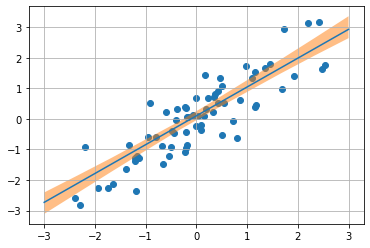

In [72]:
#pred_matrix = get_one_hot_pred_matrix(xs, kernel, prior)

plt.scatter(x,y)
plt.plot(x_plot,np.mean(pred_matrix, axis=0))
plt.fill_between(x_plot, np.max(pred_matrix, axis=0),  np.min(pred_matrix, axis=0), alpha=0.5)
#for _ in range(20):
#    plt.plot(x_plot,model([xs,gids]))
plt.grid(True)

In [24]:
xs1 = np.linspace(-3, 3, 5)
xs1 = np.expand_dims(xs1, 1)
#xs1 = np.concatenate([xs1, np.tile(np.array([1,0,0]), 5).reshape((5,3))], axis=1)
xs1 = np.concatenate([xs1,np.zeros((len(xs1), 1)).astype(np.float32)], axis=1)
gids1 = (np.zeros((10,))+0 ).astype(np.int32)
pred_matrix1 = np.concatenate([model([xs1, gids1]) for _ in range(100)], axis=1).T

xs2 = np.linspace(-3, 3, 5)
xs2 = np.expand_dims(xs2, 1)
#xs2 = np.concatenate([xs2, np.tile(np.array([0,1,0]), 5).reshape((5,3))], axis=1)
xs2 = np.concatenate([xs2,np.zeros((len(xs2), 1)).astype(np.float32)], axis=1)
gids2 = (np.zeros((10,))+1 ).astype(np.int32)
pred_matrix2 = np.concatenate([model([xs2, gids2]) for _ in range(100)], axis=1).T

xs3 = np.linspace(-3, 3, 5)
xs3 = np.expand_dims(xs3, 1)
#xs3 = np.concatenate([xs3, np.tile(np.array([0,0,1]), 5).reshape((5,3))], axis=1)
xs3 = np.concatenate([xs3,np.zeros((len(xs3), 1)).astype(np.float32)], axis=1)
gids3 = (np.zeros((10,))+2 ).astype(np.int32)
pred_matrix3 = np.concatenate([model([xs3, gids3]) for _ in range(100)], axis=1).T

InvalidArgumentError: Input to reshape is a tensor with 10 values, but the requested shape has 5 [Op:Reshape]

NameError: name 'pred_matrix1' is not defined

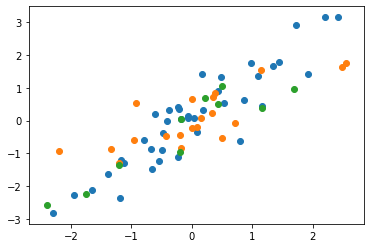

In [23]:
plt.scatter(x1,y1)
plt.scatter(x2,y2)
plt.scatter(x3,y3)

# plt.plot(np.linspace(-1, 1, 5),ys1)
# plt.plot(np.linspace(-1, 1, 5),ys2)
# plt.plot(np.linspace(-1, 1, 5),ys3)

xs1 = np.linspace(-3, 3, 5)
xs2 = np.linspace(-3, 3, 5)
xs3 = np.linspace(-3, 3, 5)

plt.plot(xs1,np.mean(pred_matrix1, axis=0))
plt.fill_between(xs1, np.max(pred_matrix1, axis=0),  np.min(pred_matrix1, axis=0), alpha=0.2)

plt.plot(xs2,np.mean(pred_matrix2, axis=0))
plt.fill_between(xs2, np.max(pred_matrix2, axis=0),  np.min(pred_matrix2, axis=0), alpha=0.2)

plt.plot(xs3,np.mean(pred_matrix3, axis=0))
plt.fill_between(xs3, np.max(pred_matrix3, axis=0),  np.min(pred_matrix3, axis=0), alpha=0.2)
plt.grid(True)

In [76]:
%tensorboard --logdir ../experiments/tensorboard/

Reusing TensorBoard on port 6007 (pid 10909), started 0:09:41 ago. (Use '!kill 10909' to kill it.)

# Radon

In [9]:
# We'll use the following directory to store files we download as well as our
# preprocessed dataset.
CACHE_DIR = os.path.join(os.sep, 'tmp', 'radon')


def cache_or_download_file(cache_dir, url_base, filename):
    """Read a cached file or download it."""
    filepath = os.path.join(cache_dir, filename)
    if tf.io.gfile.exists(filepath):
        return filepath
    if not tf.io.gfile.exists(cache_dir):
        tf.io.gfile.makedirs(cache_dir)
    url = os.path.join(url_base, filename)
    print("Downloading {url} to {filepath}.".format(url=url, filepath=filepath))
    urllib.request.urlretrieve(url, filepath)
    return filepath


def download_radon_dataset(cache_dir=CACHE_DIR):
    """Download the radon dataset and read as Pandas dataframe."""
    url_base = 'http://www.stat.columbia.edu/~gelman/arm/examples/radon/'
    # Alternative source:
    # url_base = ('https://raw.githubusercontent.com/pymc-devs/uq_chapter/'
    #             'master/reference/data/')
    srrs2 = pd.read_csv(cache_or_download_file(cache_dir, url_base, 'srrs2.dat'))
    srrs2.rename(columns=str.strip, inplace=True)
    cty = pd.read_csv(cache_or_download_file(cache_dir, url_base, 'cty.dat'))
    cty.rename(columns=str.strip, inplace=True)
    return srrs2, cty


def preprocess_radon_dataset(srrs2, cty, state='MN'):
    """Preprocess radon dataset as done in "Bayesian Data Analysis" book."""
    srrs2 = srrs2[srrs2.state==state].copy()
    cty = cty[cty.st==state].copy()
    
    # We will now join datasets on Federal Information Processing Standards
    # (FIPS) id, ie, codes that link geographic units, counties and county
    # equivalents. http://jeffgill.org/Teaching/rpqm_9.pdf
    srrs2['fips'] = 1000 * srrs2.stfips + srrs2.cntyfips
    cty['fips'] = 1000 * cty.stfips + cty.ctfips
  
    df = srrs2.merge(cty[['fips', 'Uppm']], on='fips')
    df = df.drop_duplicates(subset='idnum')
    df = df.rename(index=str, columns={'Uppm': 'uranium_ppm'})
    
    # For any missing or invalid activity readings, we'll use a value of `0.1`.
    df['radon'] = df.activity.apply(lambda x: x if x > 0. else 0.1)
    
    # Remap categories to start from 0 and end at max(category).
    county_name = sorted(df.county.unique())
    df['county'] = df.county.astype(
        pd.api.types.CategoricalDtype(categories=county_name)).cat.codes
    county_name = map(str.strip, county_name)
    
    df['log_radon'] = df['radon'].apply(np.log)
    df['log_uranium_ppm'] = df['uranium_ppm'].apply(np.log) 
    df = df[['log_radon', 'floor', 'county', 'log_uranium_ppm']]
   
    return df, county_name

In [10]:
radon, county_name = preprocess_radon_dataset(*download_radon_dataset())

In [17]:
# Save processed data. (So we can later read it in R.)
with open(os.path.join(CACHE_DIR, 'radon.csv'), 'w') as f:
    radon.to_csv(f, index=False)

In [19]:
radon.head()

,log_radon,floor,county,log_uranium_ppm
0,0.788457,1,0,-0.689048
1,0.788457,0,0,-0.689048
2,1.064711,0,0,-0.689048
3,0.000000,0,0,-0.689048
4,1.131402,0,1,-0.847313


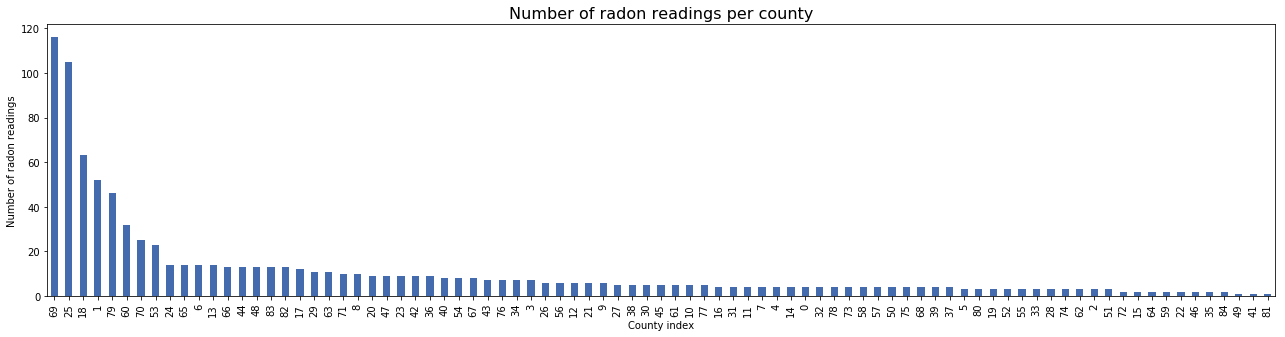

In [20]:

fig, ax = plt.subplots(figsize=(22, 5));
county_freq = radon['county'].value_counts()
county_freq.plot(kind='bar', color='#436bad');
plt.xlabel('County index')
plt.ylabel('Number of radon readings')
plt.title('Number of radon readings per county', fontsize=16)
county_freq = np.array(zip(county_freq.index, county_freq.values))  # We'll use this later.

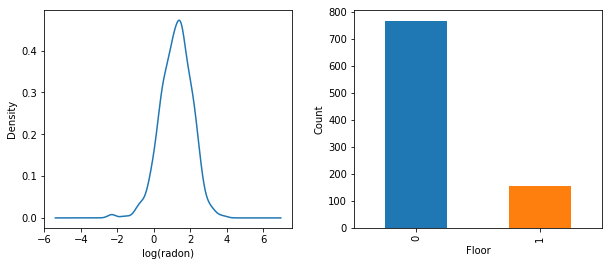

In [21]:

fig, ax = plt.subplots(ncols=2, figsize=[10, 4]);

radon['log_radon'].plot(kind='density', ax=ax[0]);
ax[0].set_xlabel('log(radon)')

radon['floor'].value_counts().plot(kind='bar', ax=ax[1]);
ax[1].set_xlabel('Floor');
ax[1].set_ylabel('Count');

fig.subplots_adjust(wspace=0.25)

In [22]:
inv_scale_transform = lambda y: np.log(y)  # Not using TF here.
fwd_scale_transform = tf.exp

In [35]:
def make_weights_prior(num_counties, dtype):
    """Returns a `len(log_uranium_ppm)` batch of univariate Normal."""
    raw_prior_scale = tf.Variable(initial_value=np.array(inv_scale_transform(1.), dtype=dtype))
    return tfp.distributions.Independent(
        tfp.distributions.Normal(
            loc=tf.zeros(num_counties, dtype=dtype),
            scale=fwd_scale_transform(raw_prior_scale)),
        reinterpreted_batch_ndims=1)


#make_weights_prior = tf.make_template(
#    name_='make_weights_prior', func_=_make_weights_prior)

In [45]:
def make_log_radon_likelihood(
    random_effect_weights, floor, county, log_county_uranium_ppm, init_log_radon_stddev):
    
    raw_likelihood_scale = tf.Variable(initial_value=np.array(
            inv_scale_transform(init_log_radon_stddev), dtype=dtype))
    fixed_effect_weights = tf.Variable(initial_value=np.array([0., 1.], dtype=dtype))
    fixed_effects = fixed_effect_weights[0] + fixed_effect_weights[1] * floor
    random_effects = tf.cast(tf.gather(
        random_effect_weights * log_county_uranium_ppm,
        indices=tf.cast(county, tf.int32),
        axis=-1), tf.float32)
    linear_predictor = fixed_effects + random_effects
    return tfp.distributions.Normal(
        loc=linear_predictor, scale=fwd_scale_transform(raw_likelihood_scale))

In [55]:
def joint_log_prob(
    random_effect_weights, log_radon, floor, county, log_county_uranium_ppm, dtype):
    num_counties = len(log_county_uranium_ppm)
    rv_weights = make_weights_prior(num_counties, dtype)
    rv_radon = make_log_radon_likelihood(
        random_effect_weights,
        floor,
        county,
        log_county_uranium_ppm,
        init_log_radon_stddev=radon.log_radon.values.std())
    #print(random_effect_weights, log_radon)
    #print(rv_weights.log_prob(random_effect_weights)
    #        , tf.reduce_sum(rv_radon.log_prob(log_radon), axis=-1))
    return (rv_weights.log_prob(random_effect_weights)
            + tf.reduce_sum(rv_radon.log_prob(log_radon), axis=-1))

### Expectation Maximization

In [47]:

# Specify unnormalized posterior.

dtype = np.float32

log_county_uranium_ppm = radon[
    ['county', 'log_uranium_ppm']].drop_duplicates().values[:, 1]
log_county_uranium_ppm = log_county_uranium_ppm.astype(dtype)

def unnormalized_posterior_log_prob(random_effect_weights):
    return joint_log_prob(
        random_effect_weights=random_effect_weights,
        log_radon=dtype(radon.log_radon.values),
        floor=dtype(radon.floor.values),
        county=np.int32(radon.county.values),
        log_county_uranium_ppm=log_county_uranium_ppm,
        dtype=dtype)

In [56]:

# Set-up E-step.

step_size = tf.Variable(
    initial_value=np.array(0.2, dtype=dtype),
    trainable=False)

hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=unnormalized_posterior_log_prob,
    num_leapfrog_steps=2,
    step_size=step_size,
    step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(
      num_adaptation_steps=None),
    state_gradients_are_stopped=True)



/Users/milesturpin/miniconda3/lib/python3.6/site-packages/tensorflow_probability/python/mcmc/internal/util.py:494: UserWarning: `step_size` is not a `tf.Tensor`, Python number, or Numpy array. If this parameter is mutable (e.g., a `tf.Variable`), then the behavior implied by `store_parameters_in_results` will silently change on 2019-08-01. Please consult the docstring for `store_parameters_in_results` details and use `store_parameters_in_results=True` to silence this warning.
  param_name))
/Users/milesturpin/miniconda3/lib/python3.6/site-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


In [ ]:
# @tf.function
# def run_chain():
#     [
#         posterior_prob,
#         posterior_centers,
#         posterior_sds
#     ], kernel_results = tfp.mcmc.sample_chain(
#         num_results=number_of_steps,
#         num_burnin_steps=burnin,
#         current_state=initial_chain_state,
#         kernel=hmc)
#     return ([
#         posterior_prob,
#         posterior_centers,
#         posterior_sds
#     ], kernel_results)

#init_random_weights = tf.placeholder(dtype, shape=[len(log_county_uranium_ppm)])
init_random_weights = [tf.Variable(np.zeros(len(log_county_uranium_ppm)), dtype=dtype)]



@tf.function
def run_chain():
    posterior_random_weights, kernel_results = tfp.mcmc.sample_chain(
        num_results=3,
        num_burnin_steps=0,
        num_steps_between_results=0,
        current_state=init_random_weights,
        kernel=hmc)
    return posterior_random_weights, kernel_results


In [63]:
# Set-up M-step.

loss = -tf.reduce_mean(kernel_results.accepted_results.target_log_prob)

#global_step = tf.train.get_or_create_global_step()
global_step = tf.Variable(1, name='global_step')

learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.1,
    #global_step=global_step,
    decay_steps=2,
    decay_rate=0.99)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
train_op = optimizer.minimize(loss, 
                              #global_step=global_step
                             )

TypeError: minimize() missing 1 required positional argument: 'var_list'

[<tf.Tensor: id=13, shape=(), dtype=float32, numpy=0.4>]

In [ ]:
maxiter = int(1500)
num_accepted = 0
num_drawn = 0
for i in range(maxiter):
    [
        _,
        global_step_,
        loss_,
        posterior_random_weights_,
        kernel_results_,
        step_size_,
        prior_scale_,
        likelihood_scale_,
        fixed_effect_weights_,
    ] = sess.run([
        train_op,
        global_step,
        loss,
        posterior_random_weights,
        kernel_results,
        step_size,
        prior_scale,
        likelihood_scale,
        fixed_effect_weights,
    ], feed_dict={init_random_weights: w_})
    w_ = posterior_random_weights_[-1, :]
    num_accepted += kernel_results_.is_accepted.sum()
    num_drawn += kernel_results_.is_accepted.size
    acceptance_rate = num_accepted / num_drawn
    if i % 100 == 0 or i == maxiter - 1:
         print('global_step:{:>4}  loss:{: 9.3f}  acceptance:{:.4f}  '
            'step_size:{:.4f}  prior_scale:{:.4f}  likelihood_scale:{:.4f}  '
            'fixed_effect_weights:{}'.format(
                global_step_, loss_.mean(), acceptance_rate, step_size_,
                prior_scale_, likelihood_scale_, fixed_effect_weights_))

## One model

In [66]:
radon.head()

,log_radon,floor,county,log_uranium_ppm
0,0.788457,1,0,-0.689048
1,0.788457,0,0,-0.689048
2,1.064711,0,0,-0.689048
3,0.000000,0,0,-0.689048
4,1.131402,0,1,-0.847313


In [74]:
from sklearn.model_selection import train_test_split

x, y = radon[['floor', 'log_uranium_ppm']].values, radon['log_radon'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=3, test_size=0.5)

In [75]:
tfd = tfp.distributions

negloglik = lambda y, p_y: -p_y.log_prob(y)

model = tf.keras.Sequential([
  #tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable),
  tf.keras.layers.Dense(1),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.05), loss=negloglik)
model.fit(x, y, epochs=500, verbose=False)

In [76]:
yhat = model(x_test)

In [77]:
yhat_mean = yhat.mean()

In [83]:
model.get_weights()

[array([[-0.67041105],
        [ 0.78343725]], dtype=float32), array([1.4535519], dtype=float32)]

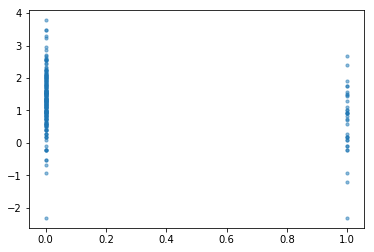

In [81]:
plt.scatter(x_test[:,0], y_test, s=10, alpha=0.5)
xs = np.linspace(0,1,4)
yhats = 
plt.plot()

## Variational Layer

In [84]:
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t, scale=1),
            reinterpreted_batch_ndims=1)),
    ])

In [64]:
def make_weights_prior(num_counties, dtype):
    """Returns a `len(log_uranium_ppm)` batch of univariate Normal."""
    raw_prior_scale = tf.Variable(initial_value=np.array(inv_scale_transform(1.), dtype=dtype))
    return tfp.distributions.Independent(
        tfp.distributions.Normal(
            loc=tf.zeros(num_counties, dtype=dtype),
            scale=fwd_scale_transform(raw_prior_scale)),
        reinterpreted_batch_ndims=1)

In [65]:
log_county_uranium_ppm

array([-0.6890476 , -0.84731287, -0.11345877, -0.5933525 , -0.14289048,
        0.3870567 ,  0.27161366,  0.2775787 , -0.33231547,  0.09586457,
       -0.6082198 ,  0.27368456, -0.7353201 ,  0.34378117, -0.05986042,
       -0.504996  ,  0.33956033, -0.6333907 , -0.02414516,  0.26385546,
        0.15571232,  0.29502505,  0.41491365,  0.22420698,  0.19661064,
       -0.09652081,  0.5035291 , -0.40059698, -0.75187224, -0.6633476 ,
        0.30902028, -0.05338601,  0.10973294, -0.00780337, -0.8818289 ,
        0.31102988, -0.6915964 , -0.6817089 ,  0.19444774,  0.44490373,
        0.3947344 ,  0.14960034,  0.01376483,  0.16586183,  0.1404226 ,
        0.02395087, -0.21005952, -0.09322665,  0.26093248,  0.39884993,
        0.24804688,  0.40545177,  0.26522171,  0.24315009, -0.20473038,
       -0.07402766, -0.16329217,  0.47860405,  0.26611108,  0.28114828,
       -0.4180535 ,  0.36632225,  0.38057798,  0.1931461 ,  0.52802485,
       -0.21204537,  0.06311563, -0.68343645,  0.23721212, -0.47